In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

from torch import nn
from corpus import SSTCorpus
from metrics import Evaluator
from tqdm import tqdm_notebook
from vanila_model import RnnVae
from sklearn.datasets.lfw import Bunch
from torch.nn.utils import clip_grad_norm_

%matplotlib inline

In [3]:
path = Bunch(
    args='vae_args.pt',
    model='vae.pt'
)

In [4]:
!nvidia-smi

Mon May 14 06:46:30 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 75%   83C    P2   173W / 250W |  10118MiB / 11171MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 45%   66C    P2    76W / 250W |   7791MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [5]:
args = Bunch(
    # Model
    model=Bunch(
        d_h=64,
        d_z=64,
        d_c=2,
        n_len=15 + 2,  # + <bos> and <eos>
        n_vocab=10000,
        d_emb=50,
        p_word_dropout=0.3,
        freeze_embeddings=False,
    ),
    # Train
    train=Bunch(
        n_batch=32,
        lr=1e-3,
        lr_decay=1000,
        n_iter=100000,
        log_interval=3000,
        grad_clipping=5,
        joint_loss=Bunch(
            start_inc=3000,
            weight=0.01,
            w_max=0.15
        ),
        bleu_val_hypot=100,
        bleu_test_hypot=100
    ),
    # Env
    device_code=1
)
# args = torch.load(path.args)

In [6]:
device = torch.device(
    f'cuda:{args.device_code}' 
    if args.device_code >= 0 and torch.cuda.is_available()
    else 'cpu'
)
device

device(type='cuda', index=1)

In [7]:
corpus = SSTCorpus(**args.model, n_batch=args.train.n_batch, device=device)

In [8]:
model = RnnVae(**args.model, x_vocab=corpus.vocab('x')).to(device)
# model = torch.load(path.model)
# model.encoder_rnn.flatten_parameters()
# model.decoder_rnn.flatten_parameters()
model

RnnVae(
  (x_emb): Embedding(5894, 50, padding_idx=0)
  (encoder_rnn): GRU(50, 64)
  (q_mu): Linear(in_features=64, out_features=64, bias=True)
  (q_logvar): Linear(in_features=64, out_features=64, bias=True)
  (decoder_rnn): GRU(116, 66)
  (decoder_fc): Linear(in_features=66, out_features=5894, bias=True)
  (conv3): Conv2d(1, 100, kernel_size=(3, 50), stride=(1, 1))
  (conv4): Conv2d(1, 100, kernel_size=(4, 50), stride=(1, 1))
  (conv5): Conv2d(1, 100, kernel_size=(5, 50), stride=(1, 1))
  (disc_fc): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=300, out_features=2, bias=True)
  )
  (encoder): ModuleList(
    (0): GRU(50, 64)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (decoder): ModuleList(
    (0): GRU(116, 66)
    (1): Linear(in_features=66, out_features=5894, bias=True)
  )
  (vae): ModuleList(
    (0): Embedding(5894, 50, padding_idx=0)
    (1): ModuleList(
      (0): GRU(50, 64)
 

In [9]:
evaluator = Evaluator(corpus)

In [10]:
class JointLossWithKLAnnealer:
    def __init__(self, **kwargs):
        self.start_inc = kwargs['start_inc']
        self.w_max = kwargs['w_max']
        
        self.weight = kwargs['weight']
        self.inc = (self.w_max - self.weight) / (kwargs['n_iter'] - self.start_inc)
    
    def __call__(self, i, kl_loss, recon_loss):
        if i >= self.start_inc and self.weight < self.w_max:
            self.weight += self.inc
        
        return self.weight * kl_loss + recon_loss

In [11]:
get_params = lambda: (p for p in model.vae.parameters() if p.requires_grad)
trainer = optim.Adam(get_params(), lr=args.train.lr)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(trainer, factor=0.01)
# lr_lambda = lambda e: args.train.lr * (0.5 ** (e // args.train.lr_decay))
# lr_schelduer = optim.lr_scheduler.LambdaLR(trainer, lr_lambda)
joint_loss = JointLossWithKLAnnealer(**args.train.joint_loss, n_iter=args.train.n_iter)

In [12]:
batcher = corpus.batcher('unlabeled', 'train', n_iter=args.train.n_iter)
t = tqdm_notebook(enumerate(batcher))
losses = []
log = []
epoch = 0
for i, x in t:
    # Forward
    kl_loss, recon_loss = model(x)
    loss = joint_loss(i, kl_loss, recon_loss)
    
    # Backward
    trainer.zero_grad()
    loss.backward()
    clip_grad_norm_(get_params(), args.train.grad_clipping)
    trainer.step()
    
    # Calc metrics and update t
    losses.append(loss.item())
    cur_loss = np.mean(losses[-args.train.log_interval:])
    kl_weight = joint_loss.weight
    lr = trainer.param_groups[0]['lr']
    t.set_postfix_str(f'loss={cur_loss:.5f} klw={kl_weight:.3f} lr={lr:.7f}')
    t.refresh()
    
    # Log
    if (i > 0 and i % args.train.log_interval == 0) or (i == args.train.n_iter - 1):
        # Epoch
        epoch += 1
        lr_scheduler.step(cur_loss, epoch=epoch)
        
        # Metrics
        sent = corpus.reverse(model.sample_sentence())
        bleu = evaluator.bleu(model, args.train.bleu_val_hypot)
        self_bleu = evaluator.self_bleu(model, args.train.bleu_val_hypot)    
        
        # Example
        bleu_5 = bleu['5-gram']
        print(f"[epoch={epoch}, bleu={bleu_5:.3f}]: '{sent}'")
        
        # Save
        log.append({
            'iter': i,
            'loss': cur_loss,
            'kl_weight': kl_weight,
            'lr': lr,
            'sent': sent,
            'bleu': bleu,
            'self_bleu': self_bleu
        })

[epoch=1, bleu=0.050]: 'amazingly guiltless , and these innuendo in go .'
[epoch=2, bleu=0.055]: 'offers full them this film ! '''
[epoch=3, bleu=0.056]: 'it 's depressing and thought-7 ride .'
[epoch=4, bleu=0.058]: 'sexy and entertaining watchable , treatment of motherhood but familiarity .'
[epoch=5, bleu=0.059]: 'and self-splitting , evelyn , brosnan 's navel of shame .'
[epoch=6, bleu=0.054]: 'if like the precisely in like you 'll made it should away .'
[epoch=7, bleu=0.061]: '... unbearably slice of gas .'
[epoch=8, bleu=0.057]: '`` frailty '' has given a movie that was intermittently harmless about they hardly ever'
[epoch=9, bleu=0.056]: 'diaz , except superb material .'
[epoch=10, bleu=0.055]: 'and the dominant christine , sylvie testud is icily brilliant .'
[epoch=11, bleu=0.057]: 'so exaggerated and broad that it is greatness in that you have been written and counterproductive'
[epoch=12, bleu=0.060]: 'ultimately inept into a brutal mid - movie is a mundane '70s kinda'
[epoc

In [13]:
class Plotter:
    def __init__(self, log):
        self.log = log
    
    def line(self, ax, name):
        if isinstance(self.log[0][name], dict):
            for k in self.log[0][name]:
                ax.plot([i[name][k] for i in self.log], label=k)
            ax.legend()
        else:
            ax.plot([i[name] for i in self.log])
            
        ax.set_ylabel('value')
        ax.set_xlabel('epoch')
        ax.set_title(name)
    
    def main_grid(self, size=15):
        _, axs = plt.subplots(nrows=2, ncols=2, figsize=(size, size))
        names = ('loss', 'kl_weight', 'bleu', 'self_bleu')
        for ax, name in zip(axs.flatten(), names):
            self.line(ax, name)

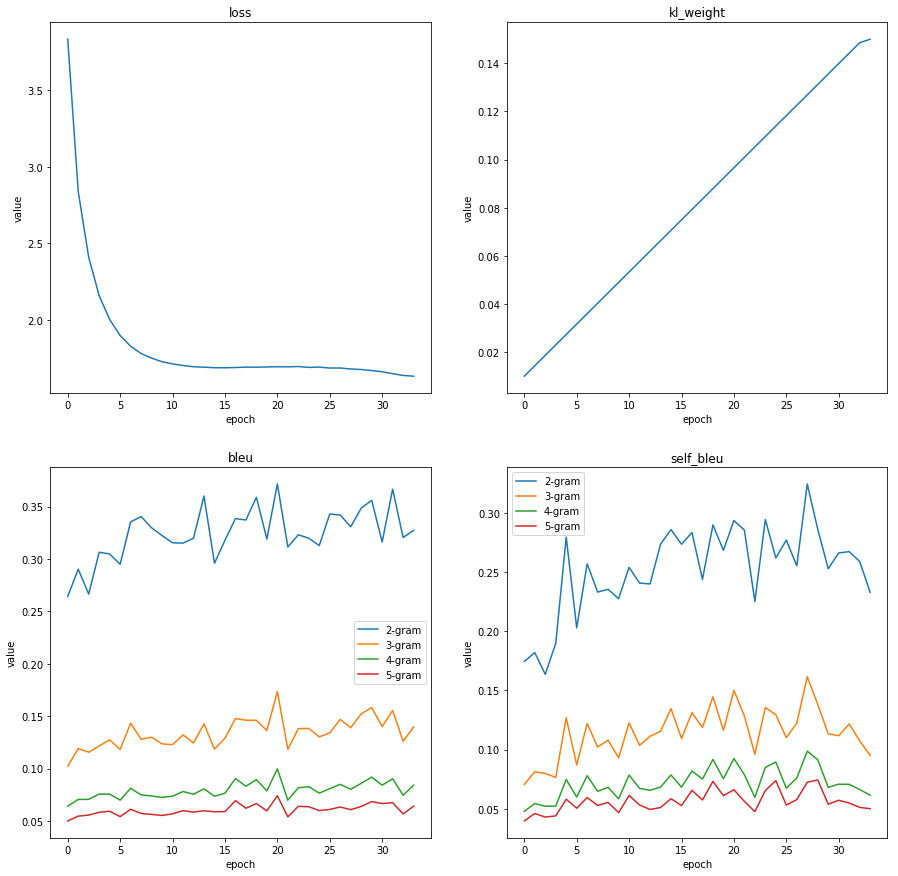

In [14]:
plotter = Plotter(log)
plotter.main_grid()

In [15]:
evaluator.bleu(model, args.train.bleu_test_hypot, 'test')

{'2-gram': 0.40607059756969927,
 '3-gram': 0.16252044329987647,
 '4-gram': 0.09476848468178245,
 '5-gram': 0.072487593571117989}

In [16]:
evaluator.self_bleu(model, args.train.bleu_test_hypot)

{'2-gram': 0.22645140559505933,
 '3-gram': 0.10597730857497389,
 '4-gram': 0.073121072052478753,
 '5-gram': 0.060597372168914809}

In [17]:
torch.save(args, path.args)
torch.save(model, path.model)